all packages 

In [16]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms

import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

load the data and select the image of 0 and 7

In [2]:
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

tr_zero_img = train_data.data[train_data.targets == 0].to(torch.float32)
tr_zero_l = train_data.targets[train_data.targets == 0]
tr_seven_img  = train_data.data[train_data.targets == 7].to(torch.float32)
tr_seven_l = torch.ones(len(tr_seven_img), dtype = torch.long)


te_zero_img = test_data.data[test_data.targets == 0].to(torch.float32)
te_zero_l = test_data.targets[test_data.targets == 0]
te_seven_img = test_data.data[test_data.targets == 7].to(torch.float32)
te_seven_l = torch.ones(len(te_seven_img), dtype = torch.long)

train = torch.cat([tr_zero_img, tr_seven_img], dim = 0)
train_l = torch.cat([tr_zero_l, tr_seven_l], dim = 0)
test = torch.cat([te_zero_img, te_seven_img], dim = 0)
test_l = torch.cat([te_zero_l, te_seven_l], dim = 0)

train_set = data.TensorDataset(*(train, train_l))
test_set = data.TensorDataset(*(test, test_l))

train_data = data.DataLoader(train_set, 32, shuffle = True) # batch size is 32
test_data = data.DataLoader(test_set, shuffle = True) 

construct the bag

In [3]:
def sample_select(sample_size, zero_part, seven_part):
    num_zero = len(zero_part)
    num_seven = len(seven_part)
    feature = torch.empty(sample_size,100, 28, 28)
    label = torch.empty(sample_size,1) 
    
    for i in range(sample_size):
        x = random.randint(0,100)  # purity in [0, 100]
        
        z_index = np.random.randint(num_zero, size = x)
        s_index = np.random.randint(num_seven, size = 100-x)
        
        z_set = zero_part[z_index]
        s_set = seven_part[s_index]
        
        mix = torch.cat([z_set, s_set], dim = 0)

        u = torch.flatten(mix, 0, 1)
        
        
        feature[i] = mix
        label[i] = x
        
    return feature, label

f, l = sample_select(2000, te_zero_img, te_seven_img)  # select 2000 bags which contian 0 and 7

part2_set = data.TensorDataset(*(f, l))
part2_loader = data.DataLoader(part2_set, shuffle = True,num_workers = 2)

CNN model to classify 0 and 7

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size = 5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size = 3)
        self.fc1 = torch.nn.Linear(800, 400)
        self.fc2 = torch.nn.Linear(400, 50)
        self.fc3 = torch.nn.Linear(50, 2)
        self.relu = torch.nn.ReLU()
        # self.dp = nn.Dropout(p = 0.5)

    def forward(self, x):
        batch_size = x.size(0)

        # two convolution 
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        
        # flatten
        x = x.view(batch_size, -1)
        
        # three full connection
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# call the model
net = CNN()

# loss function and back propagation setting
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_accs = []
train_loss = []



for epoch in range(10):
    running_loss = 0.0
    for i, sets in enumerate(train_data,0):
              
        features, labels = sets
        features = torch.unsqueeze(features, dim=1)
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()         

        net = net.cuda()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # out put the loss every 100 batchs
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d, %5d] loss :%.5f' %(epoch + 1, i + 1, running_loss/100))
            running_loss = 0.0  # reset the loss in running
        train_loss.append(loss.item())

        # record the accuracy in each batchs
        correct = 0
        total = 0
        predicted = torch.argmax(outputs.data, 1)
        total = labels.size(0) 
        correct = (predicted == labels).sum().item() 
        train_accs.append(100*correct/total)

print('Well done!')

[1,   100] loss :0.90698
[1,   200] loss :0.00790
[1,   300] loss :0.01840
[2,   100] loss :0.00404
[2,   200] loss :0.00498
[2,   300] loss :0.00201
[3,   100] loss :0.00102
[3,   200] loss :0.00051
[3,   300] loss :0.00141
[4,   100] loss :0.00017
[4,   200] loss :0.00005
[4,   300] loss :0.00038
[5,   100] loss :0.00008
[5,   200] loss :0.00006
[5,   300] loss :0.00015
[6,   100] loss :0.00006
[6,   200] loss :0.00011
[6,   300] loss :0.00005
[7,   100] loss :0.00002
[7,   200] loss :0.00004
[7,   300] loss :0.00005
[8,   100] loss :0.00002
[8,   200] loss :0.00005
[8,   300] loss :0.00002
[9,   100] loss :0.00004
[9,   200] loss :0.00002
[9,   300] loss :0.00003
[10,   100] loss :0.00002
[10,   200] loss :0.00002
[10,   300] loss :0.00003
Well done!


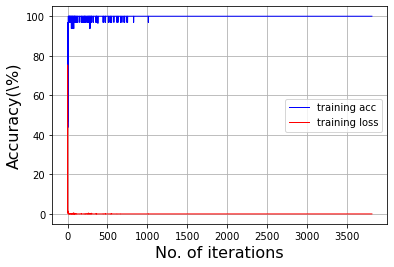

In [6]:
def plot_save(iters, loss, accs):
    plt.xlabel("No. of iterations", fontsize = 16)
    plt.ylabel("Accuracy(\%)", fontsize = 16)
    plt.plot(iters, accs, color = 'blue', label = 'training acc', linewidth = 1) 
    plt.plot(iters, loss, color = 'red', label = 'training loss', linewidth = 1) 
    plt.legend()
    plt.grid()
    plt.savefig('./ac_lo.svg', format='svg') 
    plt.show()
    
train_iters = range(len(train_accs))
plot_save(train_iters, train_loss, train_accs)


In [42]:
'''
# model statements and parameters
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor,  "\t", net.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
# save the model 
PATH = 'C:/Users/11617/Desktop/NTU/q1/data/net.pt'
torch.save(net.state_dict(), PATH)

# load the model
model = net(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''

'\n# model statements and parameters\nprint("Model\'s state_dict:")\nfor param_tensor in net.state_dict():\n    print(param_tensor,  "\t", net.state_dict()[param_tensor].size())\n\nprint("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])\n    \n# save the model \nPATH = \'C:/Users/11617/Desktop/NTU/q1/data/net.pt\'\ntorch.save(net.state_dict(), PATH)\n\n#  load the model\nmodel = net(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n'

In [26]:
# use test data to testing model performance
correct = 0
total = 0
pre = []
la = []
with torch.no_grad():
    for data in test_data:
        
        features, labels = data
        
        features = torch.unsqueeze(features, dim = 1)
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = net(features)
        predicted = torch.argmax(outputs.data, 1)
        
        pre.append(predicted.cpu().detach().numpy())
        la.append(labels.cpu().detach().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

print('Accuracy on the test data: %.3f %%' % (100 * correct / total))
# Accuracy on the test data: 99.851 %

Accuracy on the test data: 99.851 %


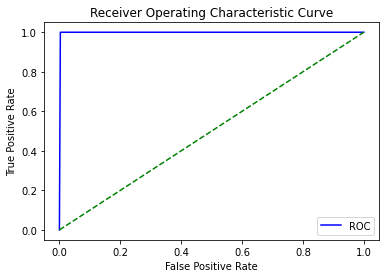

In [29]:
def p_roc(FP, TP):
    plt.plot(FP, TP, color = 'blue', label = 'ROC')
    plt.plot([0, 1], [0, 1], color = 'green', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.savefig('./roc.svg', format='svg')
    plt.show()


FP, TP, thresholds = roc_curve(la, pre)
p_roc(FP, TP)

In [13]:
# predict the purity

correct = []
ac = []
puris = []
loss = []
iters = 0
with torch.no_grad():
    
    for data in part2_loader:
        features, labels = data
        one = 0
        for f in features:
            f = torch.unsqueeze(f, dim=1)
            f = f.to(device)
            
            output = net(f)
            predict = torch.argmax(output.data, 1)
            one += predict
            iters += 1
        
        one = one.cpu().detach().numpy()
        puris = (100 - sum(one))
        total = len(f)
        correct += (puris == labels)
        loss.append(abs(puris - labels))
        
    print('Accuracy: %.3f%%, Loss: %.4f' %(sum(correct)/iters*100, sum(loss)/iters))
    
# Accuracy: 85.400%, Loss: 0.1620

Accuracy: 85.400%, Loss: 0.1620


In [14]:
# adjusted model 

correct = 0
ac = []
puris = []
loss = []
iters = 0
with torch.no_grad():
    
    for data in part2_loader:
        features, labels = data
        one = 0
        for f in features:
            f = torch.unsqueeze(f, dim=1)
            f = f.to(device)
            
            output = net(f)
            predict = torch.argmax(output.data, 1)
            one += predict
            iters += 1
        
        one = one.cpu().detach().numpy()
        puris = (100 - sum(one))
        if abs(puris - labels)<=1:
            correct += 1
        loss.append(abs(puris - labels))
        #ac.append(correct/100)
    
    print('Accuracy: %.3f%%' %(correct/iters*100))
    
# Accuracy: 98.500%

Accuracy: 98.500%
